In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

### 1. Data Preprocessing & Cleaning

In [2]:
# Load datasets
stores_df = pd.read_csv('stores.csv')
train_df = pd.read_csv('train.csv')
features_df = pd.read_csv('features.csv')
# Merge datasets
df = pd.merge(train_df, features_df, on=['Store', 'Date'])
df = pd.merge(df, stores_df, on=['Store'])
df.to_csv('sales_data.csv', index=False)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
Type                 0
Size                 0
dtype: int64

In [5]:
# Fill missing values in 'MarkDown' columns with 0
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[markdown_cols] = df[markdown_cols].fillna(0)


In [6]:
df.shape

(421570, 17)

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday_x     0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday_y     0
Type            0
Size            0
dtype: int64

In [9]:
df = df.drop(columns=['IsHoliday_y'])
df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)


### 2. Exploratory Data Analysis 

- What is the distribution of the target variable (Weekly_Sales)?

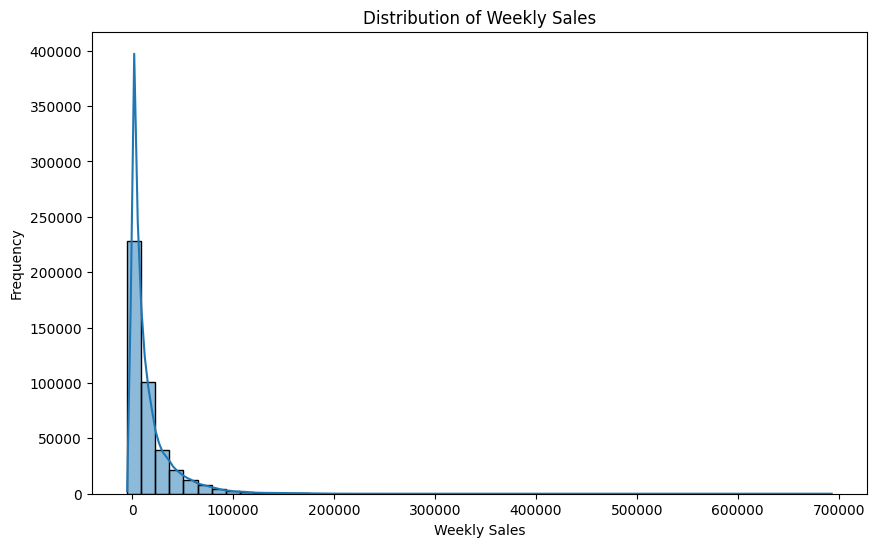

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df['Weekly_Sales'], bins=50, kde=True)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()

- How do sales vary over time?

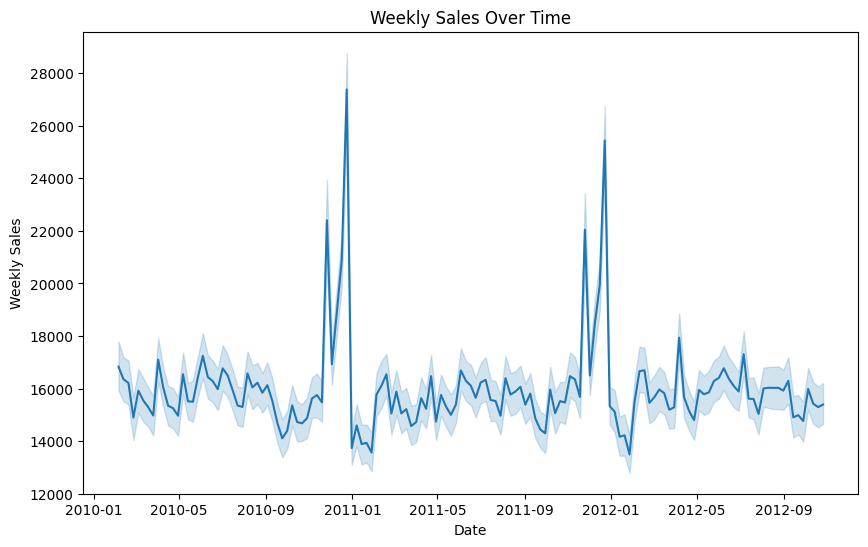

In [11]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Date', y='Weekly_Sales')
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

- How do sales differ across stores and departments?

**Average Weekly Sales by Store**

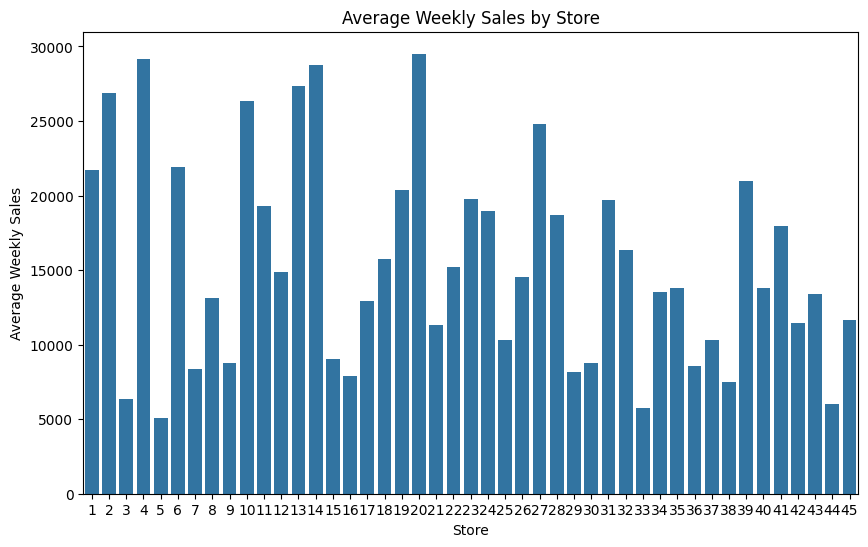

In [12]:
plt.figure(figsize=(10, 6))
store_sales = df.groupby('Store')['Weekly_Sales'].mean().reset_index()
sns.barplot(data=store_sales, x='Store', y='Weekly_Sales')
plt.title('Average Weekly Sales by Store')
plt.xlabel('Store')
plt.ylabel('Average Weekly Sales')
plt.show()

**Average Weekly Sales by Department**

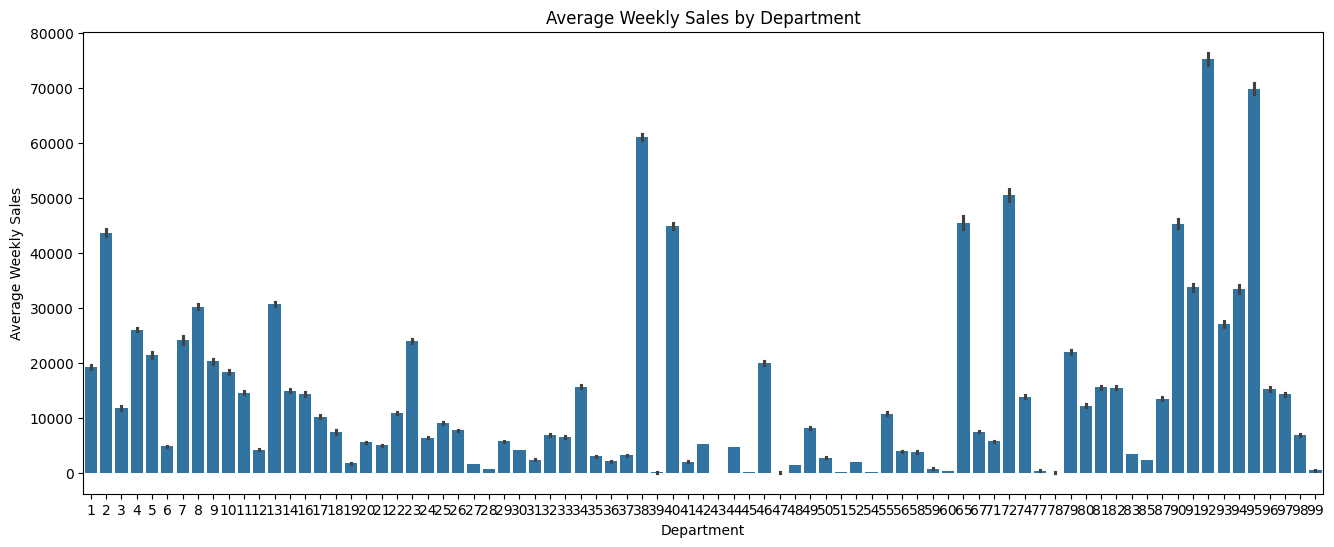

In [13]:
plt.figure(figsize=(16, 6))
sns.barplot(data=df, x= 'Dept', y='Weekly_Sales')
plt.title('Average Weekly Sales by Department')
plt.xlabel('Department')
plt.ylabel('Average Weekly Sales')
plt.show()

- What is the impact of holidays on sales?

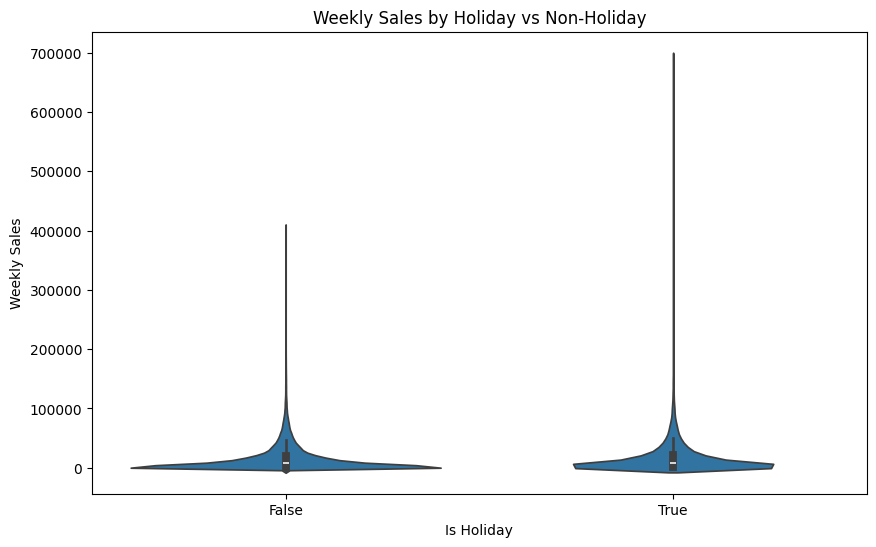

In [14]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='IsHoliday', y='Weekly_Sales')
plt.title('Weekly Sales by Holiday vs Non-Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Weekly Sales')
plt.show()

- How do external features (e.g., temperature, fuel price, CPI, unemployment) relate to sales?

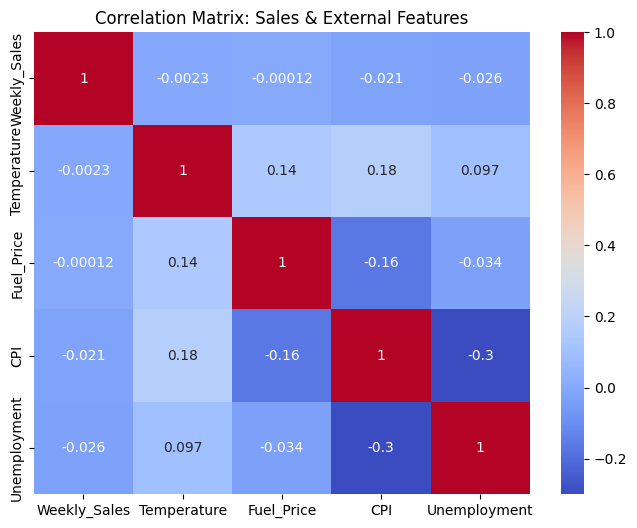

In [15]:
plt.figure(figsize=(8, 6))
corr = df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: Sales & External Features')
plt.show()

- Are there relationships between markdown events and sales?

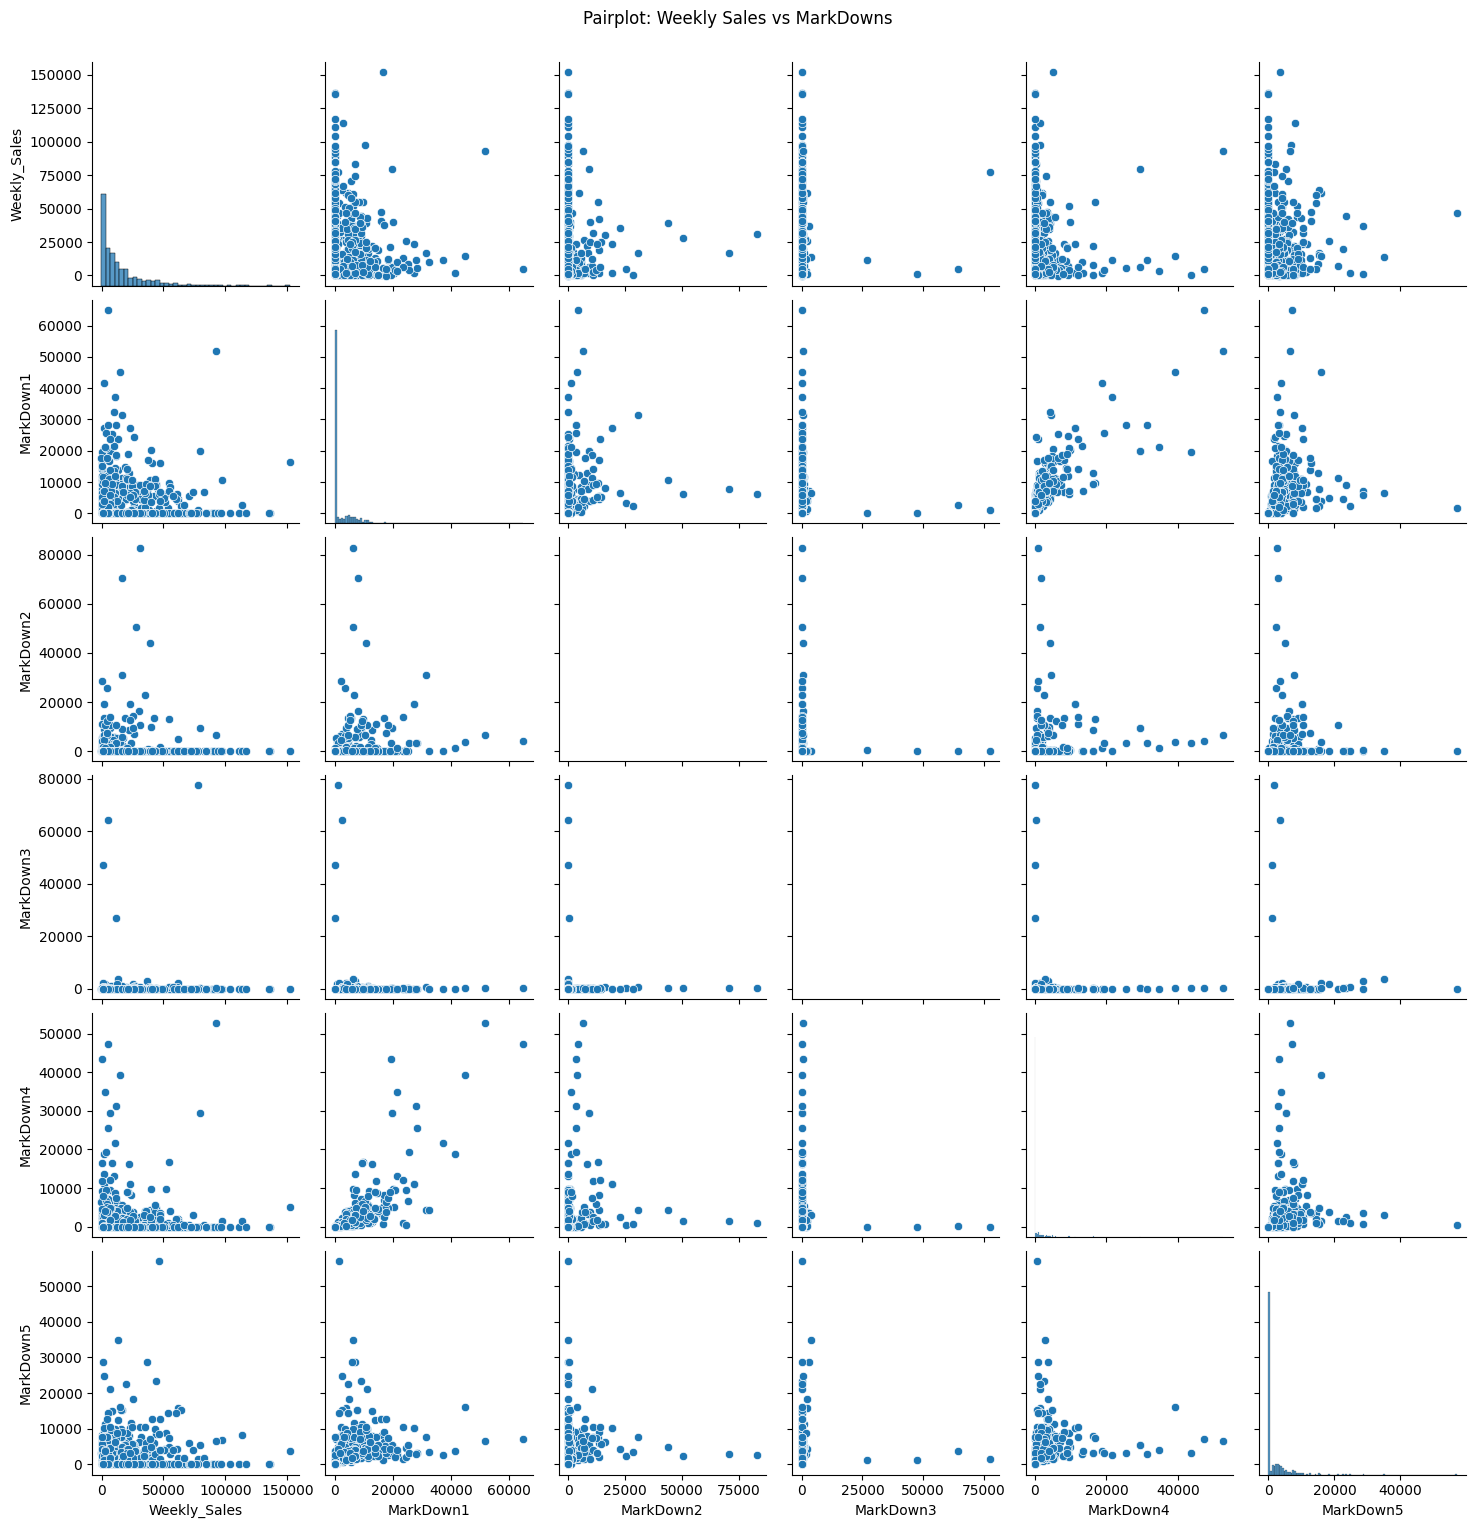

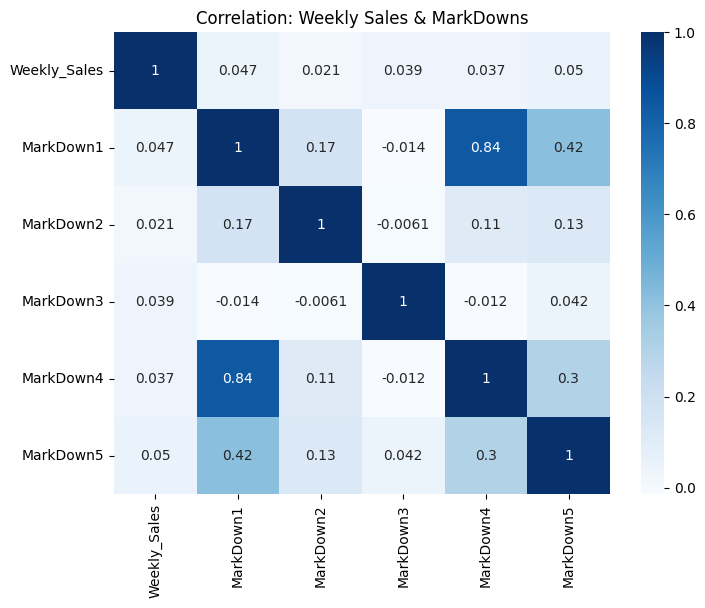

In [16]:
# Pairplot for Weekly_Sales and MarkDown features
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
sns.pairplot(df[['Weekly_Sales'] + markdown_cols].sample(1000))  # sample for speed if data is large
plt.suptitle('Pairplot: Weekly Sales vs MarkDowns', y=1.02)
plt.show()

# Correlation matrix for Weekly_Sales and MarkDowns
corr = df[['Weekly_Sales'] + markdown_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='Blues')
plt.title('Correlation: Weekly Sales & MarkDowns')
plt.show()

### Key EDA Findings

- **Weekly_Sales** is right-skewed with several outliers.
- Sales show clear **seasonality**: higher in certain months and weeks.
- **Holidays** generally increase sales, as seen in violin and box plots.
- **Store type** and **department** significantly affect average sales.
- **MarkDown events** have a weak to moderate correlation with sales.
- No major data quality issues remain after cleaning (missing values handled, duplicates removed).

### 3. Feature Engineering

In [17]:
# Date-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Example: Total MarkDown
df['Total_MarkDown'] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].sum(axis=1)

# Example: Encode Store Type if available
if 'Type' in df.columns:
    df = pd.get_dummies(df, columns=['Type'], drop_first=True)

# Example: Rolling mean of Weekly_Sales by Store (window=4)
df['Store_Rolling_Mean'] = df.groupby('Store')['Weekly_Sales'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

In [18]:
# 1. Lag feature: Previous week's sales for each Store-Dept
df['Prev_Week_Sales'] = df.sort_values('Date').groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)

# 2. Interaction feature: IsHoliday x Dept (as string for clarity)
df['Holiday_Dept'] = df['IsHoliday'].astype(str) + '_' + df['Dept'].astype(str)

# 3. Aggregated features: Average sales per Store and per Dept
df['Store_Avg_Sales'] = df.groupby('Store')['Weekly_Sales'].transform('mean')
df['Dept_Avg_Sales'] = df.groupby('Dept')['Weekly_Sales'].transform('mean')

# 4. Binning continuous variable: Temperature
df['Temp_Bin'] = pd.cut(df['Temperature'], bins=5, labels=False)

# (Optional) Fill NA values in lag feature if needed
df['Prev_Week_Sales'] = df['Prev_Week_Sales'].fillna(0)

### 4. Data Modelling

In [19]:
# Keep identifier columns separately
id_cols = df[['Date', 'Store', 'Dept']].copy()

# Feature columns for training
features = [
    'Store', 'Dept', 'Year', 'Month', 'Week', 'DayOfWeek', 'IsHoliday',
    'Total_MarkDown', 'Store_Rolling_Mean', 'Prev_Week_Sales',
    'Store_Avg_Sales', 'Dept_Avg_Sales', 'Temp_Bin'
]

X = df[features]
y = df['Weekly_Sales']

# Convert categorical variables to dummy/one-hot encoding
X = pd.get_dummies(X, drop_first=True)


### 5. Model Training

In [20]:
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, id_cols, test_size=0.2, shuffle=False)


### 6. Model Evaluation

In [21]:
# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### 7. Model Prediction

In [22]:
# Predict and evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Random Forest RMSE: {rmse:.2f}')

Random Forest RMSE: 3010.15


c:\Users\gaura\OneDrive\Desktop\my projects\PYTHON\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=200, learning_rate=0.05)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
rmse_xgb = mean_squared_error(y_test, preds, squared=False)
print(f'XGBoost RMSE: {rmse_xgb:.2f}')

XGBoost RMSE: 2769.42


c:\Users\gaura\OneDrive\Desktop\my projects\PYTHON\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [25]:
out = pd.DataFrame({
    'Date': ids_test['Date'].values,
    'Store': ids_test['Store'].values,
    'Dept': ids_test['Dept'].values,
    'Actual': y_test.values,
    'Pred_RF': y_pred,
    'Pred_XGB': preds
})


In [26]:
out.to_csv("walmart_actual_vs_pred.csv", index=False)

In [27]:
import pickle
with open('sales_model.pkl','wb') as f:
    pickle.dump(model, f)